In [1]:
# Importing necessary libraries for EDA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
 
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
nltk.download('stopwords')
 
# Importing libraries necessary for Model Building and Training
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
 
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\r_nem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv(r'C:\Users\r_nem\OneDrive\Desktop\rucha_activity\Datasets\Emails.csv')
df

,text,spam
0,Subject: enron methanol ; meter # : 988291\r\n...,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\r\nthis deal is t...,0
...,...,...
5166,Subject: put the 10 on the ft\r\nthe transport...,0
5167,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0
5168,Subject: calpine daily gas nomination\r\n>\r\n...,0
5169,Subject: industrial worksheets for august 2000...,0


In [3]:
df.head()

,text,spam
0,Subject: enron methanol ; meter # : 988291\r\n...,0
1,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,"Subject: photoshop , windows , office . cheap ...",1
4,Subject: re : indian springs\r\nthis deal is t...,0


In [4]:
df.tail()

,text,spam
5166,Subject: put the 10 on the ft\r\nthe transport...,0
5167,Subject: 3 / 4 / 2000 and following noms\r\nhp...,0
5168,Subject: calpine daily gas nomination\r\n>\r\n...,0
5169,Subject: industrial worksheets for august 2000...,0
5170,Subject: important online banking alert\r\ndea...,1


In [5]:
df.shape

(5171, 2)

In [6]:
df.describe()

,spam
count,5171.000000
mean,0.289886
std,0.453753
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [7]:
df.isnull().sum()

text    0
spam    0
dtype: int64

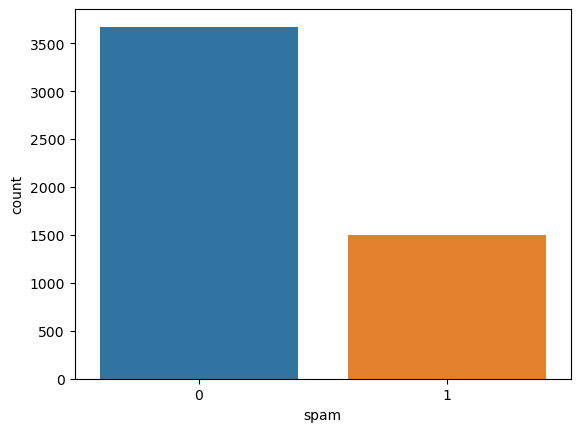

In [8]:
sns.countplot(x='spam', data=df)
plt.show()

Text(0.5, 0, 'Message types')

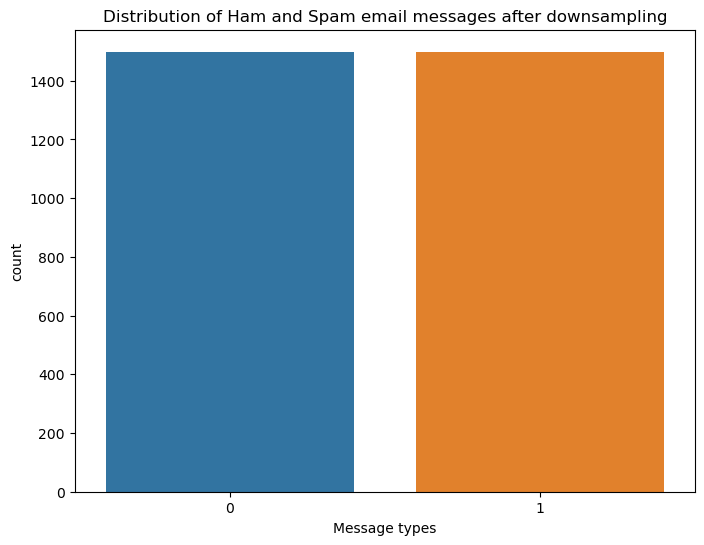

In [9]:
# Downsampling to balance the dataset
ham_msg = df[df.spam == 0]
spam_msg = df[df.spam == 1]
ham_msg = ham_msg.sample(n=len(spam_msg),random_state=42)
 
# Plotting the counts of down sampled dataset
balanced_data = ham_msg.append(spam_msg)\
    .reset_index(drop=True)
plt.figure(figsize=(8, 6))
sns.countplot(data = balanced_data, x='spam')
plt.title('Distribution of Ham and Spam email messages after downsampling')
plt.xlabel('Message types')

In [10]:
balanced_data['text'] = balanced_data['text'].str.replace('Subject', '')
balanced_data.head()

,text,spam
0,: conoco - big cowboy\r\ndarren :\r\ni ' m not...,0
1,: feb 01 prod : sale to teco gas processing\r\...,0
2,": california energy crisis\r\ncalifornia  , s...",0
3,: re : nom / actual volume for april 23 rd\r\n...,0
4,: eastrans nomination changes effective 8 / 2 ...,0


In [11]:
punctuations_list = string.punctuation
def remove_punctuations(text):
    temp = str.maketrans('', '', punctuations_list)
    return text.translate(temp)
 
balanced_data['text']= balanced_data['text'].apply(lambda x: remove_punctuations(x))
balanced_data.head()

,text,spam
0,conoco big cowboy\r\ndarren \r\ni m not sur...,0
1,feb 01 prod sale to teco gas processing\r\ns...,0
2,california energy crisis\r\ncalifornia  s p...,0
3,re nom actual volume for april 23 rd\r\nwe ...,0
4,eastrans nomination changes effective 8 2 0...,0


In [12]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')
 
    imp_words = []
 
    # Storing the important words
    for word in str(text).split():
        word = word.lower()
 
        if word not in stop_words:
            imp_words.append(word)
 
    output = " ".join(imp_words)
 
    return output
 
 
balanced_data['text'] = balanced_data['text'].apply(lambda text: remove_stopwords(text))
balanced_data.head()

,text,spam
0,conoco big cowboy darren sure help know else a...,0
1,feb 01 prod sale teco gas processing sale deal...,0
2,california energy crisis california  power cr...,0
3,nom actual volume april 23 rd agree eileen pon...,0
4,eastrans nomination changes effective 8 2 00 p...,0


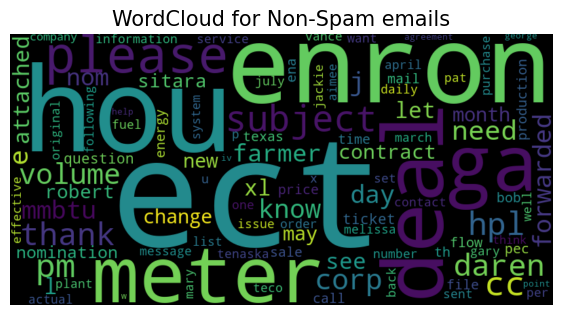

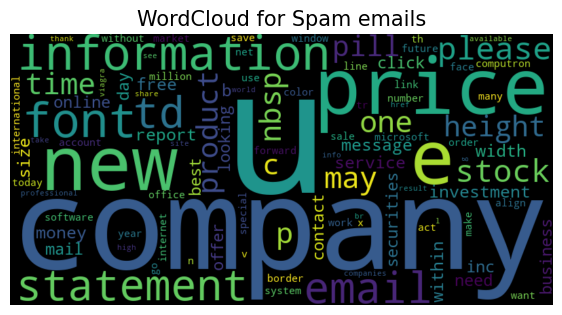

In [13]:
def plot_word_cloud(data, typ):
    email_corpus = " ".join(data['text'])
 
    plt.figure(figsize=(7, 7))
 
    wc = WordCloud(background_color='black',
                   max_words=100,
                   width=800,
                   height=400,
                   collocations=False).generate(email_corpus)
 
    plt.imshow(wc, interpolation='bilinear')
    plt.title(f'WordCloud for {typ} emails', fontsize=15)
    plt.axis('off')
    plt.show()
 
plot_word_cloud(balanced_data[balanced_data['spam'] == 0], typ='Non-Spam')
plot_word_cloud(balanced_data[balanced_data['spam'] == 1], typ='Spam')

In [14]:
#train test split
train_X, test_X, train_Y, test_Y = train_test_split(balanced_data['text'],
                                                    balanced_data['spam'],
                                                    test_size = 0.2,
                                                    random_state = 42)

In [15]:
# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_X)
 
# Convert text to sequences
train_sequences = tokenizer.texts_to_sequences(train_X)
test_sequences = tokenizer.texts_to_sequences(test_X)
 
# Pad sequences to have the same length
max_len = 100  # maximum sequence length
train_sequences = pad_sequences(train_sequences,
                                maxlen=max_len,
                                padding='post',
                                truncating='post')
test_sequences = pad_sequences(test_sequences,
                               maxlen=max_len,
                               padding='post',
                               truncating='post')

In [16]:
# Build the model
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1,
                                    output_dim=32,
                                    input_length=max_len))
model.add(tf.keras.layers.LSTM(16))
model.add(tf.keras.layers.Dense(32, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
 
# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 32)           1274912   
                                                                 
 lstm (LSTM)                 (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 32)                544       
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,278,625
Trainable params: 1,278,625
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(loss = tf.keras.losses.BinaryCrossentropy(from_logits = True),
              metrics = ['accuracy'],
              optimizer = 'adam')

In [18]:
es = EarlyStopping(patience=3,
                   monitor = 'val_accuracy',
                   restore_best_weights = True)
 
lr = ReduceLROnPlateau(patience = 2,
                       monitor = 'val_loss',
                       factor = 0.5,
                       verbose = 0)

In [19]:
# Train the model
history = model.fit(train_sequences, train_Y,
                    validation_data=(test_sequences, test_Y),
                    epochs=20,
                    batch_size=32,
                    callbacks = [lr, es]
                   )

Epoch 1/20
75/75 [==============================] - 6s 45ms/step - loss: 0.6283 - accuracy: 0.6109 - val_loss: 0.2648 - val_accuracy: 0.9650 - lr: 0.0010
Epoch 2/20
75/75 [==============================] - 3s 36ms/step - loss: 0.1754 - accuracy: 0.9612 - val_loss: 0.1291 - val_accuracy: 0.9700 - lr: 0.0010
Epoch 3/20
75/75 [==============================] - 3s 36ms/step - loss: 0.1184 - accuracy: 0.9741 - val_loss: 0.1145 - val_accuracy: 0.9750 - lr: 0.0010
Epoch 4/20
75/75 [==============================] - 3s 35ms/step - loss: 0.2101 - accuracy: 0.9458 - val_loss: 0.2342 - val_accuracy: 0.9300 - lr: 0.0010
Epoch 5/20
75/75 [==============================] - 3s 36ms/step - loss: 0.1824 - accuracy: 0.9504 - val_loss: 0.1824 - val_accuracy: 0.9517 - lr: 0.0010
Epoch 6/20
75/75 [==============================] - 3s 36ms/step - loss: 0.1158 - accuracy: 0.9737 - val_loss: 0.1837 - val_accuracy: 0.9533 - lr: 5.0000e-04


In [20]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_sequences, test_Y)
print('Test Loss :',test_loss)
print('Test Accuracy :',test_accuracy)

19/19 [==============================] - 0s 8ms/step - loss: 0.1145 - accuracy: 0.9750
Test Loss : 0.11453263461589813
Test Accuracy : 0.9750000238418579


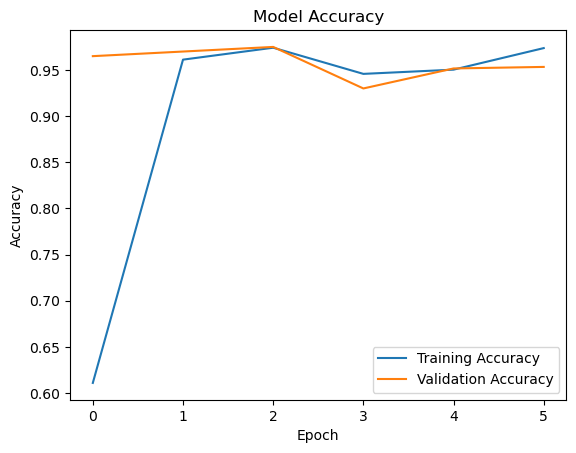

In [21]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()